# ASHW 04

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
from scipy.signal import find_peaks

## 1. zadatak

In [22]:
mase_cr = np.load("bhm.npy").flatten()
np.random.seed(42)
masses = np.random.choice(mase_cr, size=10000, replace=True)
std_dev = np.std(masses, ddof=1)
median = np.median(masses)
skewness = skew(masses)
print(std_dev)
print(median)
print(skewness)

7.066748485349409
26.51785933476059
-0.18289579090912955


In [24]:
#bootstrap
#nasumicno biranje podataka iz originalne grupe sa vracanjem
n_boot=10000
boot_samples=np.random.choice(masses,size=(n_boot,len(masses)), replace=True)

boot_std=np.std(boot_samples,axis=1,ddof=1)
boot_median = np.median(boot_samples, axis=1)
boot_skew = np.array([skew(sample) for sample in boot_samples])

boot_std_err = np.std(boot_std)
boot_median_err = np.std(boot_median)
boot_skew_err = np.std(boot_skew)

#jackknife
#slicno kao bootstrap ali se sad izostavi neki podatak
#prilagodjena iz stackoverflow
def jackknife(data,func,K=10000):
    n = len(data)
    rng = np.random.default_rng(0)
    estimates = np.zeros(K)

    np.random.seed(42)  # 42 je odgovor na sve
    
    for i in range(K):
        # Nasumično biramo dva različita indeksa
        indices_to_remove = np.random.choice(n, size=2, replace=False)
        
        mask = np.ones(n, dtype=bool) #maska bez ta dva 
        mask[indices_to_remove] = False
        estimates[i] = func(data[mask])

    mean_estimate = np.mean(estimates)
    std_error = np.std(estimates)

    return mean_estimate, std_error,estimates

jk_std_mean, jk_std_err, jk_std_raw = jackknife(masses, lambda x: np.std(x, ddof=1))
jk_median_mean, jk_median_err, jk_median_raw = jackknife(masses, np.median)
jk_skew_mean, jk_skew_err, jk_skew_raw = jackknife(masses, skew)

In [26]:
from tabulate import tabulate

data = [
    ["asimetrija", skewness,boot_skew_err,jk_skew_err ],
    ["medijana", median, boot_median_err, jk_skew_err],
    ["standardna devijacija", std_dev,boot_std_err,jk_std_err],
]
headers = ["statistika", "vrednost","bootstrap","jackknife"]

table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+-----------------------+------------+-------------+-------------+
| statistika            |   vrednost |   bootstrap |   jackknife |
+=======================+============+=============+=============+
| asimetrija            |  -0.182896 |   0.0234156 | 0.000334939 |
+-----------------------+------------+-------------+-------------+
| medijana              |  26.5179   |   0.119159  | 0.000334939 |
+-----------------------+------------+-------------+-------------+
| standardna devijacija |   7.06675  |   0.0464629 | 0.000682105 |
+-----------------------+------------+-------------+-------------+


In [28]:
#dodavanje 10 ekstremnih vrednosti
masses_ex = np.concatenate([masses, np.ones(10)*10000])
std_ex = np.std(masses_ex,ddof=1)
median_ex = np.median(masses_ex)
skew_ex = skew(masses_ex)

data = [
    ["original", std_dev,median,skewness ],
    ["extra vrednosti", std_ex, median_ex, skew_ex],
]
headers = ['statistics', "std deviation","median","skewness"]

table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+-----------------+-----------------+----------+------------+
| statistics      |   std deviation |   median |   skewness |
+=================+=================+==========+============+
| original        |         7.06675 |  26.5179 |  -0.182896 |
+-----------------+-----------------+----------+------------+
| extra vrednosti |       315.183   |  26.5243 |  31.5673   |
+-----------------+-----------------+----------+------------+


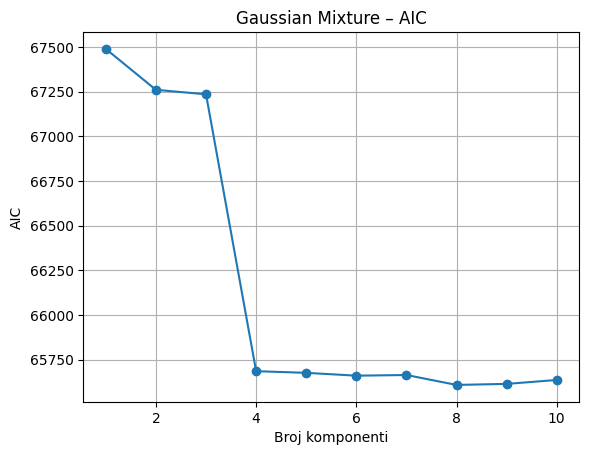

In [42]:
#hocu da plotujem peakove za najbolji broj komponenti
X = masses.reshape(-1, 1)
aics = []
n_components_range = range(1, 11)
models = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X)
    aics.append(gmm.aic(X))
    models.append(gmm)

index = np.argmin(aics)+1 #jer je 7. u skupu od 1,11 zapravo 7+1 jer pocinje od 1


plt.figure()
plt.plot(n_components_range, aics, marker='o')
plt.xlabel("Broj komponenti")
plt.ylabel("AIC")
plt.title("Gaussian Mixture – AIC")
plt.grid(True)
plt.show()

+--------+-------------+-----------+
|   peak |   masa [M☉] |   Gustina |
+========+=============+===========+
|      1 |       14.31 |    0.0111 |
+--------+-------------+-----------+
|      2 |       20.23 |    0.0942 |
+--------+-------------+-----------+
|      3 |       25.36 |    0.0427 |
+--------+-------------+-----------+
|      4 |       28.66 |    0.0542 |
+--------+-------------+-----------+
|      5 |       31.75 |    0.0595 |
+--------+-------------+-----------+


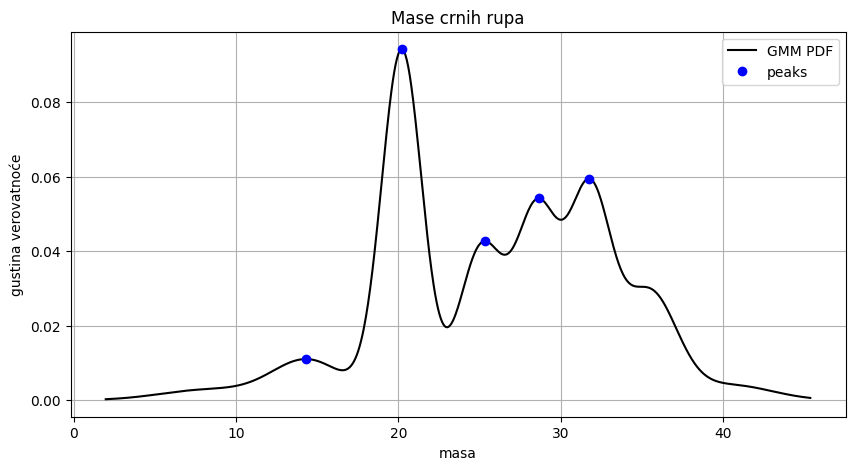

In [44]:
x_vals = np.linspace(min(masses), max(masses), 1000)
pdf = np.zeros_like(x_vals)

gmm = GaussianMixture(n_components=index, random_state=42)
gmm.fit(masses.reshape(-1, 1))

for w, mu, sigma in zip(gmm.weights_, gmm.means_.flatten(), np.sqrt(gmm.covariances_).flatten()):
    #funkcija normalne raspodele:
    comp_pdf = w * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x_vals - mu)**2 / (2 * sigma**2))
    pdf += comp_pdf

peaks= find_peaks(pdf, height=0)[0]

table = []
for i, idx in enumerate(peaks):
    masa = x_vals[idx]
    gustina = pdf[idx]
    table.append([i + 1, f"{masa:.2f}", f"{gustina:.4f}"])

headers = ["peak", "masa [M☉]", "Gustina"]
print(tabulate(table, headers=headers, tablefmt="grid"))

plt.figure(figsize=(10, 5))
plt.plot(x_vals, pdf, label='GMM PDF', color='black')
plt.plot(x_vals[peaks], pdf[peaks], "bo", label="peaks")
plt.xlabel(r"masa")
plt.ylabel("gustina verovatnoće")
plt.title("Mase crnih rupa")
plt.legend()
plt.grid(True)
plt.show()

najbolji broj:  {8}


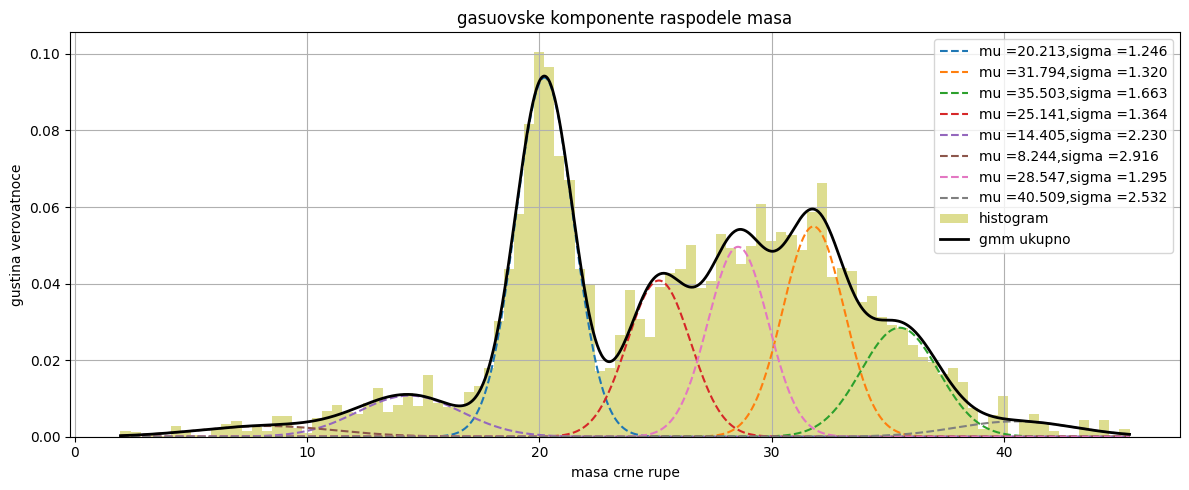

In [69]:
best_index = np.argmin(aics)
best_model = models[best_index]
print("najbolji broj: ",{n_components_range[best_index]})

x_vred = np.linspace(min(masses),max(masses),1000)
pdf = np.zeros_like(x_vred)

plt.figure(figsize=(12,5))
for w,mu,sigma in zip(best_model.weights_,best_model.means_.flatten(),(np.sqrt(best_model.covariances_).flatten())):
    comp_pdf = w*(1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x_vred-mu)**2 /(2*sigma**2))
    pdf +=comp_pdf
    plt.plot(x_vred,comp_pdf,linestyle="--", label=f"mu ={mu:.3f},sigma ={sigma:.3f}")

plt.hist(masses,bins=100,density=True, alpha =0.5, label="histogram")
plt.plot(x_vred, pdf, color="black",linewidth=2,label="gmm ukupno")
plt.title('gasuovske komponente raspodele masa')
plt.xlabel('masa crne rupe')
plt.ylabel('gustina verovatnoce')
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

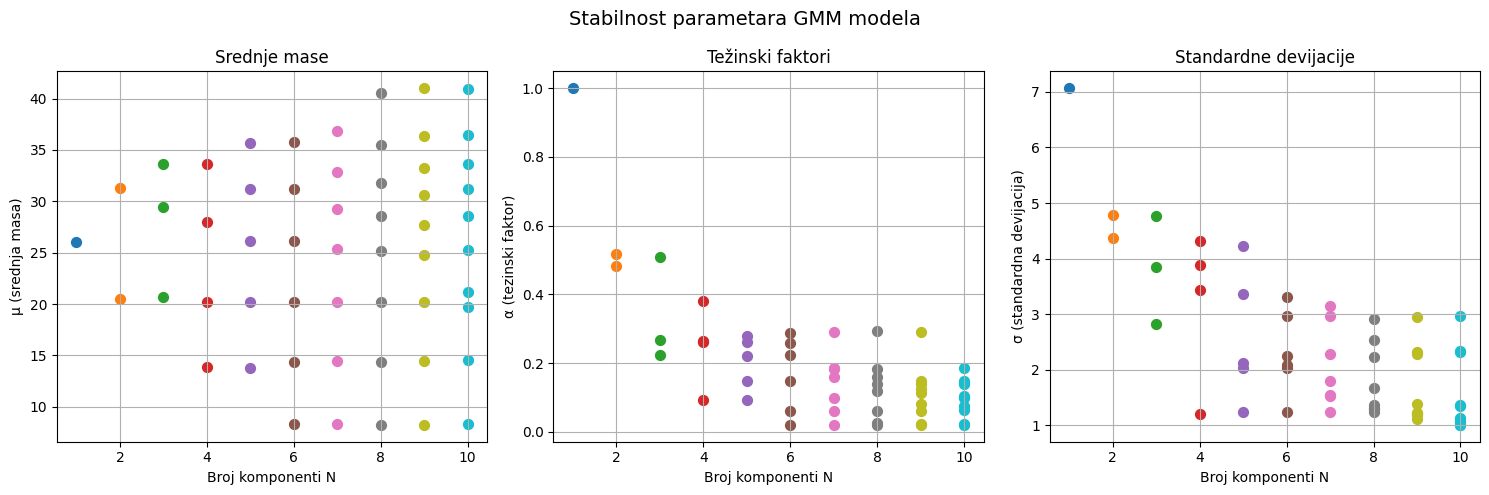

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# mu—srednje mase
for n, model in zip(n_components_range, models):
    mus = model.means_.flatten()
    axes[0].scatter([n]*len(mus), mus, s=50)
axes[0].set_xlabel("Broj komponenti N")
axes[0].set_ylabel("μ (srednja masa)")
axes[0].set_title("Srednje mase")
axes[0].grid(True)

# weights—težinski faktori
for n, model in zip(n_components_range, models):
    alphas = model.weights_.flatten()
    axes[1].scatter([n]*len(alphas), alphas, s=50)
axes[1].set_xlabel("Broj komponenti N")
axes[1].set_ylabel("α (tezinski faktor)")
axes[1].set_title("Težinski faktori")
axes[1].grid(True)

# sigma— standardne devijacije
for n, model in zip(n_components_range, models):
    sigmas = np.sqrt(model.covariances_).flatten()
    axes[2].scatter([n]*len(sigmas), sigmas, s=50)
axes[2].set_xlabel("Broj komponenti N")
axes[2].set_ylabel("σ (standardna devijacija)")
axes[2].set_title("Standardne devijacije")
axes[2].grid(True)

plt.suptitle("Stabilnost parametara GMM modela", fontsize=14)
plt.tight_layout()
#plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()